# Setup

## Packages

In [15]:
!git clone https://github.com/lurosenb/superquail
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install folktables

fatal: destination path 'superquail' already exists and is not an empty directory.


In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [17]:
import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import time 
from tqdm import tqdm

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

import BlackBoxAuditing
%matplotlib notebook

## Load data

We have included code to read in the folktables dataset. The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as is for the following analyses.

For more information on the this dataset, please see the following paper:
https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | Dropped from this analysis to focus on one sensitive attribute |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [18]:
np.random.seed(13) # do not change the seed

# read in the folktables dataset 
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=30000)
full_df = full_df.drop(columns='RAC1P') # drop race -- another protected attribute from our dataset

print(full_df.shape)
full_df.head()

(30000, 10)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
0,44.0,1.0,1.0,1.0,4220.0,6.0,10.0,40.0,1.0,0.0
1,66.0,2.0,20.0,2.0,4720.0,42.0,0.0,32.0,2.0,0.0
2,72.0,6.0,18.0,1.0,10.0,6.0,1.0,8.0,2.0,1.0
3,53.0,1.0,21.0,1.0,1460.0,457.0,0.0,40.0,1.0,1.0
4,55.0,1.0,16.0,1.0,220.0,6.0,1.0,40.0,1.0,0.0


## Set protected attribute and target

In [19]:
protected_attr = 'SEX' # set sex as the protected attribute
target = 'PINCP' # personal income as the target, note that [1 = >50k]

In [20]:
# convert this dataframe into an aif360 dataset
original_data = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=full_df,
    label_names=[target],
    protected_attribute_names=[protected_attr])
privileged_groups = [{protected_attr: 1}] 
unprivileged_groups = [{protected_attr: 2}]

## Split data

In [21]:
seed = 50
train_data, test_data = original_data.split([0.8], shuffle=True, seed=seed)

## Scale features in the data

In [22]:
scaler = MinMaxScaler()

train_data.features = scaler.fit_transform(train_data.features)
test_data.features = scaler.transform(test_data.features)

# convert to dataframes
train_df, _ = train_data.convert_to_dataframe()
test_df, _ = test_data.convert_to_dataframe()
print("Training set: ", train_df.shape)
print("Test set: ", test_df.shape)

# extract x (features) and y (target)
train_x = train_df.drop([target, protected_attr], axis=1)
train_y = train_df[target]
test_x = test_df.drop([target, protected_attr], axis=1)
test_y = test_df[target]

Training set:  (24000, 10)
Test set:  (6000, 10)


## Train a random forest model (baseline)

In [23]:
# use these hyperparameters in your call to RandomForestClassifier
n_estimators = 20
max_depth = 10

# set up the random forest model, using the hyperparameters
clf = RandomForestClassifier(max_depth=max_depth, n_estimators = n_estimators)

# fit the model using the training data (train_x, train_y)
clf.fit(train_x, train_y)

RandomForestClassifier(max_depth=10, n_estimators=20)

## Calculate metrics

In [24]:
# the below function has been provided for you. You can use this function to
# convert your data to a StandardDataset format for use in AIF360
def transform_to_aif(df, target=target, protected_attr=protected_attr):
  '''convert a pandas.DataFrame to a StandardDataset used in AIF360'''

  sd = StandardDataset(
      df,
      label_name = target,
      favorable_classes = [1],
      protected_attribute_names = [protected_attr],
      privileged_classes = [[1]]
  )

  return sd




In [36]:


# convert predictions data to AIF StandardDataset
original_data = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=full_df,
    label_names=[target],
    protected_attribute_names=[protected_attr])

# also create AIF StandardDataset versions of training and test data

train_standard = transform_to_aif(train_df, target=target, protected_attr=protected_attr)
test_standard = transform_to_aif(test_df, target=target, protected_attr=protected_attr)

In [37]:
# calculate metrics
y_hat = clf.predict(test_x)

#convert predictions data to AIF StandardDataset
trained_preds = train_df.copy()
trained_preds['PINCP'] = clf.predict(train_x)
#recode predictions to match format: 1 = good credit, 2 = bad income
trained_preds['PINCP'] = trained_preds.PINCP.replace({0, 2})

#create aif StandardDataset for training and test datasets
orig_aif360 = StandardDataset(train_df,
                              label_name='PINCP',
                              protected_attribute_names=['SEX'], 
                              privileged_classes=[[1]], favorable_classes=[1])
preds_aif360 = StandardDataset(trained_preds,
                               label_name='PINCP',
                               protected_attribute_names=['SEX'], 
                               privileged_classes=[[1]], favorable_classes=[1])



#metrics
pred_metrics = BinaryLabelDatasetMetric(preds_aif360,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
print("Mean difference = %f" % pred_metrics.mean_difference())
print("Disparate Impact = %f" % pred_metrics.disparate_impact())


orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())

print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())

Mean difference = -0.061586
Disparate Impact = 0.857283

Error rate difference (unprivileged error rate - privileged error rate)= -0.014671

False negative rate for privileged groups = 0.215599
False negative rate for unprivileged groups = 0.189612
False negative rate ratio = 0.879463

False positive rate for privileged groups = 0.126050
False positive rate for unprivileged groups = 0.133216
False positive rate ratio = 1.056846


In [40]:
#calculate all metrics
accuracy = orig_vs_preds_metrics.accuracy
auc = roc_auc_score(test_y, y_hat)
priv_accuracy = orig_vs_preds_metrics.accuracy(privileged=True)
unpriv_accuracy = orig_vs_preds_metrics.accuracy(privileged = False)
disparate_impact = pred_metrics.disparate_impact()
fn_priv = orig_vs_preds_metrics.false_negative_rate(privileged=True)
fn_unpriv = orig_vs_preds_metrics.false_negative_rate(privileged=False)
fn_ratio = orig_vs_preds_metrics.false_negative_rate_ratio()
fp_priv = orig_vs_preds_metrics.false_positive_rate(privileged=True)
fp_unpriv = orig_vs_preds_metrics.false_positive_rate(privileged=False)
fp_ratio = orig_vs_preds_metrics.false_positive_rate_ratio()
fp_rate_difference = orig_vs_preds_metrics.false_discovery_rate_difference()

print("accuracy:", accuracy)
# print("AUC:", auc)
print("Privileged accuracy:", priv_accuracy)
print("Unprivileged Accuracy: ", unpriv_accuracy)
print("Disparate Impact: ", disparate_impact)
print("False Positive Rate Difference: ", fp_rate_difference)


accuracy: <bound method ClassificationMetric.accuracy of <aif360.metrics.classification_metric.ClassificationMetric object at 0x7f7008ccb710>>
Privileged accuracy: 0.8323982615566969
Unprivileged Accuracy:  0.8470691934773028
Disparate Impact:  0.8572834544789694
False Positive Rate Difference:  0.07765018368165852


## Transform the original data using Disparate Impact Remover at five repair levels and calculate metrics

In [42]:
# the below function has been provided for you. You can use this function to
# plot the repair_level (on the x-axis) against a given metric,
# e.g. accuracy, on the y-axis
def plot_metric_repair(repair_levels, metric_values, metric_name):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_values, color='#0384fc', linewidth=3, label=metric_name)


  # Create labels, etc. 
  plt.xlabel('Repair level')
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

In [43]:
#prior to creating loops, create function of the metrics cell to save time when running cell
def metrics(model, x_test, y_test):
    
    # Calculate predicted values
    y_pred = model.predict(x_test)

    test_df_pred = test_df.copy()
    test_df_pred['PINCP'] = y_pred
    
    orig_aif360 = StandardDataset(test_df, label_name='PINCP',favorable_classes=[1],
                                       protected_attribute_names=['SEX'],privileged_classes=[[1]])

    pred_aif360 = StandardDataset(test_df_pred, label_name='PINCP',favorable_classes=[1],
                                       protected_attribute_names=['SEX'],privileged_classes=[[1]])
    
    orig_vs_preds_metrics = ClassificationMetric(orig_aif360, pred_aif360,
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups)
    
    metric_pred = BinaryLabelDatasetMetric(pred_aif360,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
  

    #calculate accuracy 
    accuracy = orig_vs_preds_metrics.accuracy()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred)

    #Accuracy for priviledged groups 
    priv_accuracy = orig_vs_preds_metrics.accuracy(privileged=True)

    #Accuracy for unprivileged groups
    unpriv_accuracy = orig_vs_preds_metrics.accuracy(privileged=False)
   
    #Disparate impact
    disparate_impact = metric_pred.disparate_impact()

    #false positive rate difference
    fp_rate_difference = orig_vs_preds_metrics.false_positive_rate_difference()

    return accuracy, auc, priv_accuracy, unpriv_accuracy, disparate_impact, fp_rate_difference


In [52]:
seeds = [1,2,3,4,5,6,7,8,9, 10]
repair_levels = [0.2, 0.4, 0.6, 0.8, 1]
i = 0

disparate_imapacts = []
accuracies = []
priv_accuracies = []
unpriv_accuracies = []
fprate_difference = []  


for seed in seeds:
  print(seed)
  #split
  train_orig, test_orig = original_data.split([0.8], shuffle = True, seed = seed)
  train_orig, val_orig = train_orig.split([0.875], shuffle=True)

  #scale
  train_orig.features = scaler.fit_transform(train_orig.features)
  test_orig.features = scaler.fit_transform(test_orig.features)

  disparate_imapacts = []
  aucs = []
  accuracies = []
  priv_accuracies = []
  unpriv_accuracies = []
  fprate_difference = []  
  
  for repair_level in repair_levels:
    #apply remover with given repair value
    DIR = DisparateImpactRemover(repair_level=repair_level, sensitive_attribute = 'SEX')
    DIR_train = DIR.fit_transform(train_orig)
    DIR_test = DIR.fit_transform(test_orig)

    #convert to dataframe
    DIR_train_df,_= DIR_train.convert_to_dataframe()
    DIR_test_df,_ = DIR_test.convert_to_dataframe()

    #fit the best model for this split 

    x_train = DIR_train_df.drop('PINCP',axis=1)
    y_train = DIR_train_df['PINCP']
    x_test = DIR_test_df.drop('PINCP', axis = 1)
    y_test = DIR_test_df['PINCP']

    #build model
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    clf.fit(x_train, y_train)
    
    #report metrics
    rando_forest_preds = DIR_test_df.copy()
    rando_forest_preds['PINCP'] = clf.predict(x_test)

    #calculate metrics
    accuracy, auc, priv_accuracy, unpriv_accuracy, disparate_impact, fp_rate_difference = metrics(model=clf,x_test = x_test,y_test=y_test)

    
 
    accuracies.append(accuracy)
    aucs.append(auc)
    priv_accuracies.append(priv_accuracy)
    unpriv_accuracies.append(unpriv_accuracy)
    disparate_imapacts.append(disparate_impact)
    fprate_difference.append(fp_rate_difference)

  i=i+1




1


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

2


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

3


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

4


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

5


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

6


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

7


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

8


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

9


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

10


RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

RandomForestClassifier(max_depth=10, n_estimators=20)

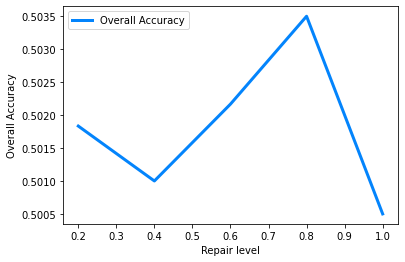

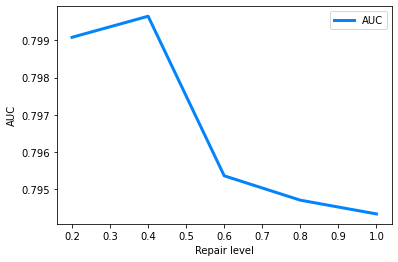

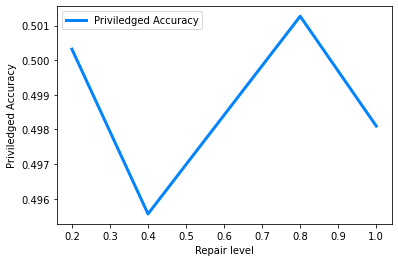

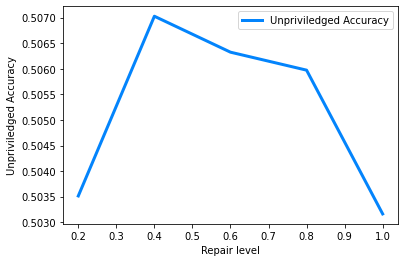

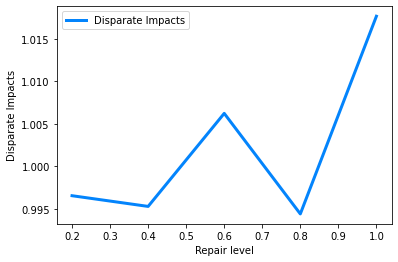

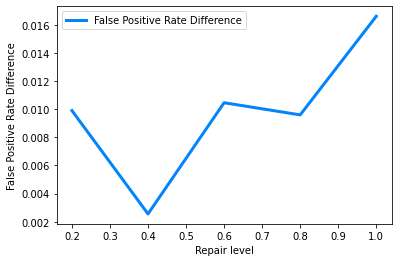

In [58]:
# plot each metric against the repair level
# you can use the plot_metric_repair above)
  #plots
plot_metric_repair(repair_levels=repair_levels,metric_values=accuracies,metric_name="Overall Accuracy")
plot_metric_repair(repair_levels = repair_levels, metric_values = aucs, metric_name = "AUC")
plot_metric_repair(repair_levels=repair_levels,metric_values=priv_accuracies,metric_name="Priviledged Accuracy")
plot_metric_repair(repair_levels=repair_levels,metric_values=unpriv_accuracies,metric_name="Unpriviledged Accuracy")
plot_metric_repair(repair_levels=repair_levels,metric_values=disparate_imapacts,metric_name="Disparate Impacts")
plot_metric_repair(repair_levels=repair_levels,metric_values=fprate_difference,metric_name="False Positive Rate Difference")


## Train a Prejudice Remover model at three eta values and calculate metrics


In [67]:
etas = [0.01, 0.1, 1] # eta is the weight we apply to the fairness regularization parameter

# train a Prejudice Remover model at these eta values and calculate metrics
# (you may wish to use a for loop)

# train a Prejudice Remover model at these eta values and calculate metrics
train_data2, test_data2 = original_data.split([0.8], shuffle=True, seed=seed)
# (you may wish to use a for loop)
disparate_impacts = []
aucs = []
accuracies = []
priv_accuracies = []
unpriv_accuracies = []
fprate_difference = []
for e in etas:
  print("eta: ",e)
  currentPrejudiceRemover = PrejudiceRemover(eta=e)
  currentPrejudiceRemover.fit(train_data2)
  predictions = currentPrejudiceRemover.predict(test_data2)
  metrics = ClassificationMetric(
      test_data2,
      predictions,
      unprivileged_groups=unprivileged_groups,
      privileged_groups=privileged_groups
    )
  accuracy = metrics.accuracy()
  DIR  = metrics.disparate_impact()
  accuracies.append(accuracy)
  disparate_impacts.append(DIR)
  print("Accuracy: ",accuracy)
  print("Disperate Impact: ",DIR)

eta:  0.01


Accuracy:  0.7521666666666667
Disperate Impact:  0.6092980949012078
eta:  0.1


Accuracy:  0.752
Disperate Impact:  0.6096851966133433
eta:  1


Accuracy:  0.752
Disperate Impact:  0.6096851966133433


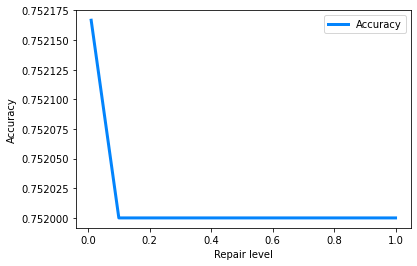

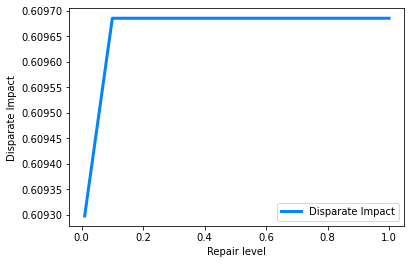

In [68]:
# plot one or more of the metrics varies at the different values of eta
plot_metric_repair(etas, accuracies, "Accuracy")
plot_metric_repair(etas, disparate_impacts, "Disparate Impact")